In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer
from sklearn.linear_model import Ridge, SGDRegressor
from catboost import CatBoostRegressor
%matplotlib inline

In [2]:
NULL = 'None'
train_df = pd.read_csv('./50K_1K_R_train.csv')
test_df = pd.read_csv('./50K_1K_R_test.csv')

In [3]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,509382,Pink Nation Burgandy Pullover,3,Women/Tops & Blouses/Blouse,PINK,15.0,0,Wayyyy to big for me Tags say xs but it's huge...
1,817141,Anastasia Beverly Hills Duo 12 brush,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,6.0,1,I know you want your product asap so will ship...
2,683208,Washington Redskins pajama bottoms,2,Sports & Outdoors/Fan Shop/NFL,NaN,9.0,0,Washington Redskins pajama bottoms silky for w...
3,502742,Baby boy the north face 2 pc jogger,3,Kids/Boys 0-24 Mos/Coats & Jackets,The North Face,16.0,0,Size 12-18 months in great condition
4,113524,Chanel Nail Polish,2,Beauty/Makeup/Nails,NaN,18.0,1,Used once Still full


In [4]:
print(train_df.shape)
print(train_df.info())

(50000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
train_id             50000 non-null int64
name                 50000 non-null object
item_condition_id    50000 non-null int64
category_name        49817 non-null object
brand_name           28484 non-null object
price                50000 non-null float64
shipping             50000 non-null int64
item_description     50000 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 3.1+ MB
None


### Features description
- train_id or test_id - the id of the listing
- name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. ```$20```) to avoid leakage. These removed prices are represented as [rm]
- item_condition_id - the condition of the items provided by the seller
- category_name - category of the listing
- brand_name
- price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
- shipping - 1 if shipping fee is paid by seller and 0 by buyer
- item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. ```$20```) to avoid leakage. These removed prices are represented as [rm]


In [5]:
def fillna():
    train_df['category_name'].fillna(NULL, inplace=True)
    train_df['brand_name'].fillna(NULL, inplace=True)
    train_df['item_description'].fillna(NULL, inplace=True)

fillna()

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
train_id             50000 non-null int64
name                 50000 non-null object
item_condition_id    50000 non-null int64
category_name        50000 non-null object
brand_name           50000 non-null object
price                50000 non-null float64
shipping             50000 non-null int64
item_description     50000 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 3.1+ MB


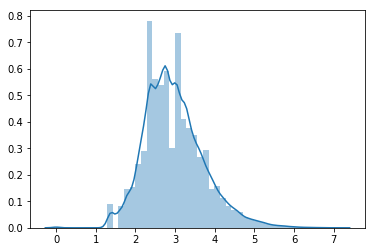

In [7]:
sns.distplot(np.log1p(train_df['price'].values))

In [54]:
#small_train_df = train_df[train_df['price'] > np.float64(0.0)].iloc[:100000]

In [55]:
#small_train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,None,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,None,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,None,44.0,0,Complete with certificate of authenticity


In [8]:
cat_model = CatBoostRegressor(loss_function='RMSE')
cross_val_score(
    cat_model,
    train_df[['item_condition_id', 'category_name', 'brand_name', 'shipping']].values,
    train_df['price'].values,
    fit_params={'cat_features': [0, 1, 2, 3]}
)


array([ 1007.14891497,   964.50011564,  1137.57361645])

In [63]:
for i in cross_val_score(
    Pipeline([
        ('cv', CountVectorizer()),
        ('sgdr', SGDRegressor())
    ]),
    train_df['item_description'],
    train_df['price'],
    scoring=make_scorer(mean_squared_error),
):
print(np.sqrt(i))

/home/totaki/soft/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/totaki/soft/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/to

36.2614683389
33.0575222041
35.447190721


In [58]:
sum(small_train_df['price'] == np.float64(0.0))

0

In [64]:
pipe = Pipeline([
        ('cv', CountVectorizer()),
        ('sgdr', SGDRegressor())
    ])

In [65]:
pipe.fit(
    small_train_df['item_description'],
    small_train_df['price']
)

/home/totaki/soft/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_a...      power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

In [69]:
pipe.predict([train_df['item_description'][200000]])

array([ 24.60192646])

In [70]:
train_df['price'][200000]

12.0

In [87]:
np.append(np.array([1, 2]), np.array([3, 4]), axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [81]:
small_train_df['item_description'].values

array(['No description yet',
       'This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.',
       'Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!',
       ..., 'Romper/dress and cardigan',
       'New! Cute 2 piece set, girls size 5. Long purple sweater dress with leggings! New, tag says retail [rm]',
       'Brand new and high quality/brand professional hair thing shear'], dtype=object)

In [89]:
np.array(zip([1, 2, 3], [4, 5, 6]))

array(<zip object at 0x7f41a142c748>, dtype=object)

In [ ]:
np